In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn')

We first run the script example_pred_variation.py to generate the prediction results. The scripts looks specifically at variations between training runs and the effect of spinning up on the predictions

In [2]:
#load data from output of example_pred_variation.py
lyap = 0.9056
var = np.load('results/pred_variation.npz', allow_pickle = True)
x = [np.vstack(x) for x in var['x']]
var = var['pred'].astype(np.float64)/lyap

# Effect of Training

We analyze the distribution of predictions for different reservoirs all with the same parameters.  This shows the effect of random variations in the connectivity matrix as well as in Win, training data...etc. 10 reservoirs were trained and then predictions were generated for 4000 different randomly generated time series per reservoir.

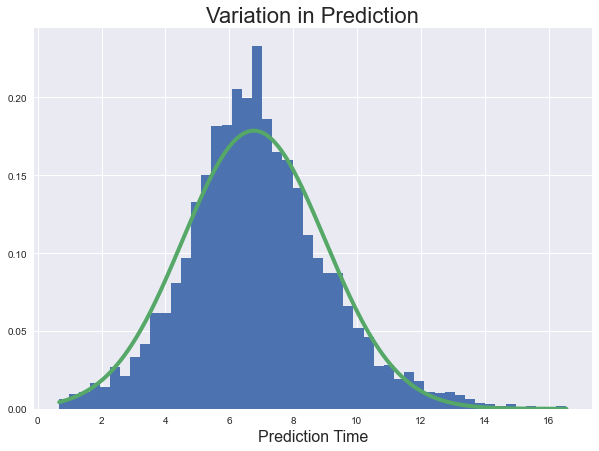

In [3]:
fig = plt.figure(figsize = (10, 7))
i = 0
plt.hist(var[i], density = True, bins = 50);


xmin, xmax = np.min(var[i]), np.max(var[i])  
lnspc = np.linspace(xmin, xmax, len(var[i]))


# get mean and standard deviation  
m = np.median(var[i])
s = np.std(var[i])
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm", lw = 4) # plot it
plt.xlabel('Prediction Time', fontsize = 16)
plt.title('Variation in Prediction', fontsize = 22);
# fig.savefig('results/var_pred.pdf', bbox_inches = 'tight')

In [4]:
np.mean(np.median(var, axis = 1)), np.std(np.median(var, axis = 1))

(7.214774734982332, 0.29054996016606405)

The mean prediction time is 7.21 with std 2.20


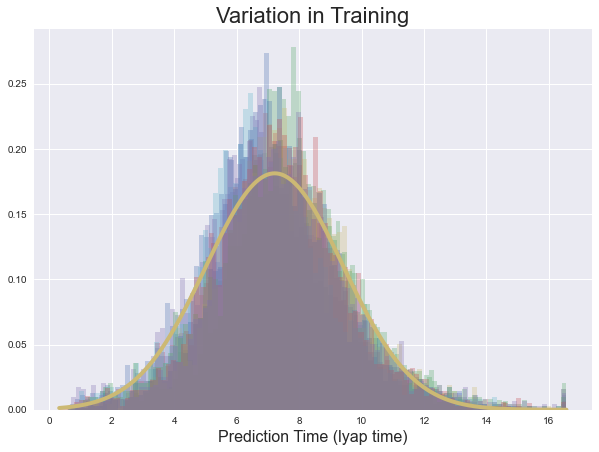

In [5]:
fig = plt.figure(figsize = (10, 7))
for i in range(len(var)):
    plt.hist(var[i], density = True, bins = 100, alpha = 0.3);

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
var_train = np.mean(var, axis = 0)
# xt = plt.xticks()[0]  
xmin, xmax = np.min(var), np.max(var)  
lnspc = np.linspace(xmin, xmax, len(var_train))

# get mean and standard deviation  
m = np.mean(np.median(var, axis = 1)) 
s = np.mean(np.std(var, axis = 1))
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm", lw = 4) # plot it
plt.xlabel('Prediction Time (lyap time)', fontsize = 16)
plt.title('Variation in Training', fontsize = 22);
print('The mean prediction time is {:1.2f} with std {:1.2f}'.format(m, s))
fig.savefig('results/train_var.pdf', bbox_inches = 'tight')

To me this shows that there is a slight variation between the trained reservoirs but not that much O(1 lyapunov time).  Therefore the random selection of connections and Win as well as the training data does not effect the predictability of the reservoir that much.

# Predictability on Location in the Attractor

Given that there is an range of values given for each trained reservoir we can take a look at which points tend to have better predictions across all the attractors.

Plotted here is the position on the attractor at which the prediction starts and the color indicates the predictability.

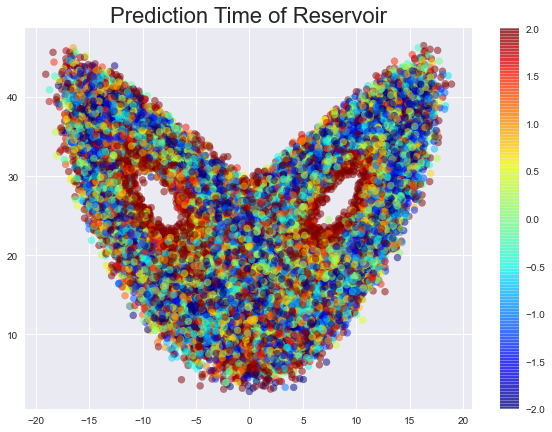

In [36]:
fig = plt.figure(figsize = (10, 7))
for i in range(len(var))[::-1]:
    plt.scatter(x[i][:, 0], x[i][:, 2], c = var[i]-np.median(var[i]),
                cmap = 'jet', alpha = 0.5, vmin = -2, vmax = 2)
plt.colorbar()
plt.title('Prediction Time of Reservoir', fontsize = 22);
fig.savefig('results/pred_time_res.png', bbox_inches = 'tight')

What this indicates is that the centers of the lobes and the outside give good predictions while the center middle part of the attractor tends to give worse predictions.

The thought that these areas might correspond to the finite time lyapunov exponents (FTLE)

The below plot shows the highest prediction values (Blue) and the lowest prediction values (Red).  Notice how the blue seems to cluster in the middle of the lobes and the very outside of the attractor while the red is in a central band.

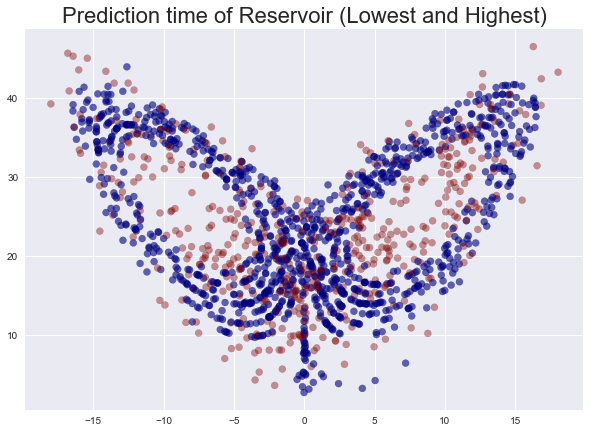

In [50]:
fig = plt.figure(figsize = (10, 7))
high = 6
low = -4
for i in range(len(var)):
    v = var[i]-np.median(var[i])
    maskh = v > high
    maskl = v < low
    plt.scatter(x[i][maskl][:, 0], x[i][maskl][:, 2], c = v[maskl],
        cmap = 'jet', alpha = 0.6, vmin = low, vmax = high)
    plt.scatter(x[i][maskh][:, 0], x[i][maskh][:, 2], c = v[maskh],
                cmap = 'jet', alpha = 0.4, vmin = low, vmax = high)

plt.title('Prediction time of Reservoir (Lowest and Highest)', fontsize = 22);
fig.savefig('results/pred_time_res_lowhigh.png')

Very interestingly the very lowest predictions seem to be collected in a particular trajectory. This holds for all of the 10 reservoirs.  The highest predictions have no such pattern

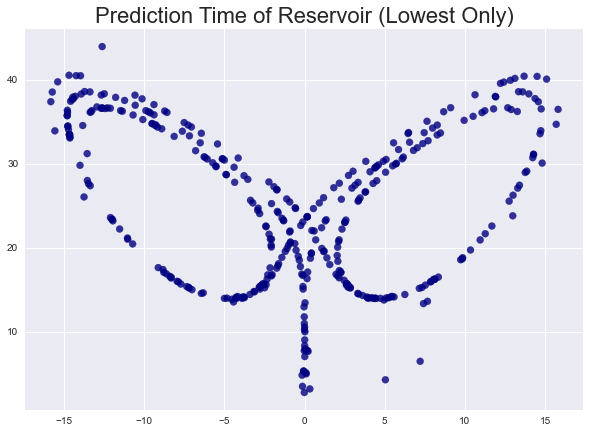

In [31]:
fig = plt.figure(figsize = (10, 7))
for i in range(len(var)):
    low = 2
    maskl = var[i] < low
    plt.scatter(x[i][maskl][:, 0], x[i][maskl][:, 2], c = var[i][maskl],
            cmap = 'jet', alpha = 0.8, vmin = low, vmax = low+1)
plt.title('Prediction Time of Reservoir (Lowest Only)', fontsize = 22);
# fig.savefig('results/pred_time_res_low.pdf', bbox_inches = 'tight')

# Correlation of Prediction with FTLE

To see if the prediction time is correlated with the FTLE we calculate the FTLE for the starting prediction point and then do a linear regression over the prediction time

In [3]:
%%time
import sys
sys.path.insert(1, '../')
from system import *

sigma = 10   # Prandlt number
rho = 28     # Rayleigh number
beta = 8.0/3

D = 3

#lorenz63 model
def lorenz(n, t, p):
    sigma, rho, beta = p
    x, y, z = n
    dxdt = sigma*(y-x)
    dydt = x*(rho-z)-y
    dzdt = x*y - beta*z
    dXdt = [dxdt, dydt, dzdt]
    return dXdt

def jac(X, t, p):
    sigma, rho, beta = p
    x, y, z = X
    return np.array([[-sigma, sigma, 0],
                     [-z+rho, -1, -x],
                     [y, x, -beta]])

# build the system from the dynamical equations
lor63sys = system(lorenz, (sigma, rho, beta), D, 0.001, fjac = jac)

CPU times: user 57.4 ms, sys: 27.2 ms, total: 84.6 ms
Wall time: 107 ms


In [4]:
L = 32
dt = 0.05
T = L*dt
skip = 2
X = np.vstack(x)
v = np.hstack([v - np.median(v) for v in var])

#4.8
high = v > 4
low = v < -4
# inds = np.random.choice(X.shape[0], X.shape[0]//skip, replace = False)
inds = np.logical_or(high, low)
X = X[inds]

In [5]:
%%time
LE = lor63sys.localExp(X, L, dt, multi = True)

CPU times: user 336 ms, sys: 104 ms, total: 440 ms
Wall time: 11min 16s


In [6]:
print('Calculated FTLE with T = {:1.2f}'.format(T))

Calculated FTLE with T = 1.60


In [7]:
np.sum(high), np.sum(low)

(1878, 1131)

In [8]:
import scipy
LLE = LE[:, 0]

# v = np.hstack([var_i - np.median(var_i) for var_i in var])[inds]
result = scipy.stats.linregress(LLE, v[inds])

This is a plot of the FTLE vs Prediction time.  The linear regression shows there is a negative correlation between the FTLE and prediction time. Thus as the FTLE increases the prediction time decreases as one would expect

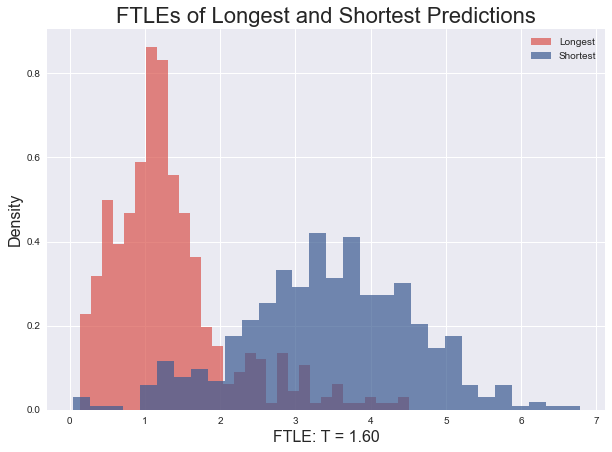

In [14]:
import seaborn as sns
fig = plt.figure(figsize = (10, 7))
plt.hist(LLE[v[inds] > 6.1], bins = 30,
         alpha = 0.7, density = True,
         label = 'Longest', color = sns.xkcd_rgb["pale red"]);
plt.hist(LLE[v[inds] < -5], bins = 30,
         alpha = 0.7, density = True, label = 'Shortest',
         color = sns.xkcd_rgb["denim blue"]);
plt.title('FTLEs of Longest and Shortest Predictions', fontsize = 22)
plt.xlabel('FTLE: T = {:1.2f}'.format(T), fontsize = 16)
plt.ylabel('Density', fontsize = 16)
plt.legend();
fig.savefig('results/FTLE_Long_Short.pdf', bbox_inches = 'tight')

In [108]:
np.median(LLE[v[inds] < -4]), np.std(LLE[v[inds] < 4])

(1.6790641712668426, 1.3204702040152962)

In [109]:
np.median(LLE)

1.296780837502235

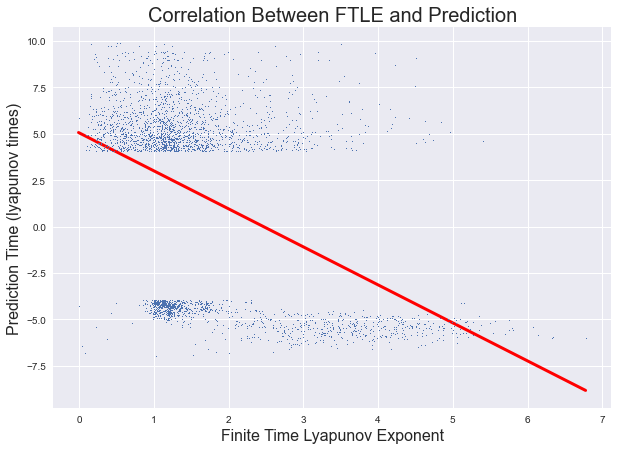

In [92]:
fig = plt.figure(figsize = (10, 7))
x_lle = np.arange(np.min(LLE), np.max(LLE), 0.01)
plt.plot(x_lle, result.slope*x_lle+result.intercept, lw = 3, c = 'r')
plt.plot(LLE, v[inds], ',')
plt.xlabel('Finite Time Lyapunov Exponent', fontsize = 16)
plt.ylabel('Prediction Time (lyapunov times)', fontsize = 16)
plt.title('Correlation Between FTLE and Prediction', fontsize = 20);
fig.savefig('corr_ftle_pred_T3.2.pdf', bbox_inches = 'tight')

In [ ]:
result.pvalue

We see that the pvalue is significantly lower than 0.01 thus we can reject the null hypothesis and say with certainty that the FTLE is correlated with prediction time.

# Low Prediction Points

In [8]:
X_tot = np.vstack(x)
v_tot = np.hstack([var_i - np.median(var_i) for var_i in var])
inds_low = v_tot < -4

X_low = X_tot[inds_low]
v_low = v_tot[inds_low]
LE = lor63sys.localExp(X_low, L, dt, multi = True)

ValueError: x and y must be the same size

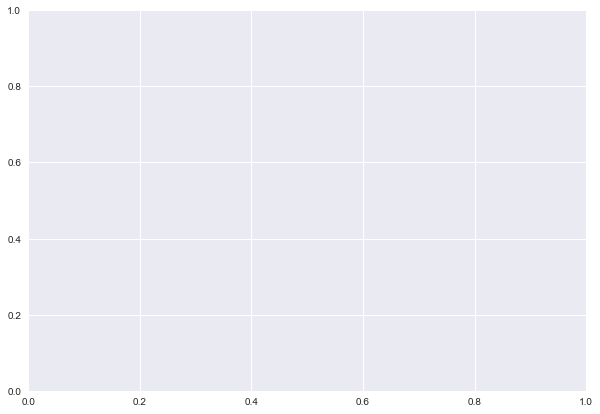

In [110]:
fig = plt.figure(figsize = (10, 7))
plt.scatter(LE[:, 0], v_low)
plt.axvline(1.28, color = 'r', lw = 3)
plt.xlabel('FTLE', fontsize = 16)
plt.ylabel('Prediction', fontsize = 16)
plt.title('Low Prediction Points', fontsize = 20)
# fig.savefig('Low_Prediction_Points.pdf', bbox_inches = 'tight')

These are all the low prediction points. The red bar indicates the average FTLE for all points.  Therefore we see that low prediction points tend to have high FTLE.